In [1]:
from numpy import *

def loadDataSet(filename):
	numFeat = len(open(filename).readline().split('\t')) - 1
	dataMat = []
	labelMat = []
	fr = open(filename)
	for line in fr.readlines():
		lineArr = []
		curLine = line.strip().split('\t')
		for i in range(numFeat):
			lineArr.append(float(curLine[i]))
		dataMat.append(lineArr)
		labelMat.append(float(curLine[-1]))
	return dataMat, labelMat

#computes the best-fit line
def standRegres(xArr, yArr):
	xMat = mat(xArr)
	yMat = mat(yArr).T
	xTx = xMat.T * xMat
	if linalg.det(xTx) == 0.0:#check if the determinate is zero
		print("This matrix is singular, cannot do inverse")
		return 
	ws = xTx.I * (xMat.T * yMat)
	return ws

#Locally weighted linear regression function
#to generate a yHat estimate for any point in the x space
#function lwlr: input the testpoint
#function lwlrTest: get the yHat
def lwlr(testPoint, xArr, yArr, k = 1.0):
	xMat = mat(xArr); yMat = mat(yArr).T
	m = shape(xMat)[0]
	weights = mat(eye((m)))#diagonal matrix
	for j in range(m):
		diffMat = testPoint - xMat[j,:]
		weights[j,j] = exp(diffMat * diffMat.T / (-2.0 * k ** 2))# populate weights with exponentially decaying values
	xTx = xMat.T * (weights * xMat)
	if linalg.det(xTx) == 0.0:
		print("This matrix is singular, cannot do inverse")
		return 
	ws = xTx.I * (xMat.T * (weights * yMat))
	return testPoint * ws

def lwlrTest(testArr, xArr, yArr, k = 1.0):
	m = shape(testArr)[0]
	yHat = zeros(m)
	for i in range(m):
		yHat[i] = lwlr(testArr[i], xArr, yArr, k)
	return yHat

In [2]:
xArr,yArr = loadDataSet('E:\python\machinelearning\MLDownloads\machinelearninginaction\Ch08\ex0.txt')
xArr[0:2]

[[1.0, 0.067732], [1.0, 0.42781]]

In [3]:
yArr[0]

3.176513

In [4]:
lwlr(xArr[0],xArr,yArr,1.0)

matrix([[3.12204471]])

In [5]:
lwlr(xArr[0],xArr,yArr,0.0001)

matrix([[3.17647975]])

In [6]:
yHat = lwlrTest(xArr,xArr,yArr,0.003)
yHat[0]

3.2020066489821457

In [7]:
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:,0,:]
import matplotlib.pyplot as plt 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],mat(yArr).T.flatten().A[0], s = 2, c = 'green')
ax.plot(xSort[:,1], yHat[srtInd])
plt.show()

<Figure size 640x480 with 1 Axes>

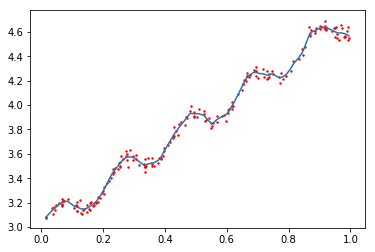

In [8]:
fig = plt.figure()
yHat = lwlrTest(xArr,xArr,yArr,0.01)
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],mat(yArr).T.flatten().A[0], s = 2, c = 'red')
ax.plot(xSort[:,1], yHat[srtInd])
plt.show()

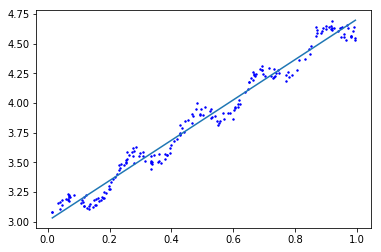

In [9]:
fig = plt.figure()
yHat = lwlrTest(xArr,xArr,yArr,1)
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0],mat(yArr).T.flatten().A[0], s = 2, c = 'blue')
ax.plot(xSort[:,1], yHat[srtInd])
plt.show()

In [10]:
def rssError(yArr, yHatArr):
    return((yArr - yHatArr) ** 2).sum()

In [11]:
abX, abY = loadDataSet('E:\\python\\machinelearning\\MLDownloads\\machinelearninginaction\\Ch08\\abalone.txt')
yHat01 = lwlrTest(abX[0:999],abX[0:999],abY[0:999],0.1)
yHat1 = lwlrTest(abX[0:99],abX[0:99],abY[0:99],1)
yHat10 = lwlrTest(abX[0:99],abX[0:99],abY[0:99],10)

In [12]:
rssError(abY[0:999],yHat01.T)

12311.663234486785

In [13]:
rssError(abY[0:99],yHat1.T)

429.89056187030394

In [14]:
rssError(abY[0:99],yHat10.T)

549.1181708826065

In [15]:
yHat01 = lwlrTest(abX[100:199],abX[0:99],abY[0:99],0.1)
rssError(abY[100:199],yHat01.T)

25119.459111157415

In [16]:
yHat1 = lwlrTest(abX[100:199],abX[0:99],abY[0:99],1)
rssError(abY[100:199],yHat1.T)

573.5261441895706

In [17]:
yHat10 = lwlrTest(abX[100:199],abX[0:99],abY[0:99],10)
rssError(abY[100:199],yHat10.T)

517.5711905381745

In [18]:
ws = standRegres(abX[0:99],abY[0:99])
yHat = mat(abX[100:199]) * ws
rssError(abY[100:199],yHat.T.A)

518.6363153249365

In [19]:
def ridgeRegres(xMat, yMat, lam = 0.2):
    xTx = xMat.T * xMat
    denom = xTx + eye(shape(xMat)[1]) * lam
    if linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T * yMat)
    return ws

def ridgeTest(xArr, yArr):
    xMat = mat(xArr); yMat = mat(yArr).T
    yMean = mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = mean(xMat, 0)
    xVar = var(xMat, 0)
    xMat = (xMat - xMeans) /  xVar
    numTestPts = 30
    wMat = zeros((numTestPts,shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat, yMat, exp(i - 10))
        wMat[i,:] = ws.T
    return wMat
                 

In [20]:
abX, abY = loadDataSet('E:\\python\\machinelearning\\MLDownloads\\machinelearninginaction\\Ch08\\abalone.txt')
ridgeWeight = ridgeTest(abX,abY)

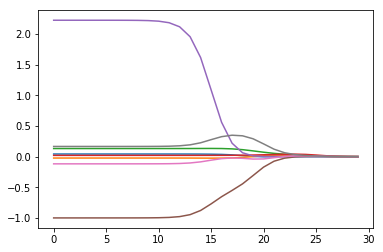

In [21]:
fig = plt.figure()
yHat = lwlrTest(xArr,xArr,yArr,1)
ax = fig.add_subplot(111)
#ax.scatter(xMat[:,1].flatten().A[0],mat(yArr).T.flatten().A[0], s = 2, c = 'blue')
ax.plot(ridgeWeight)
plt.show()